In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Indian_Rainfall/rainfaLLIndia.csv')
df

,subdivision,YEAR,JUN,JUL,AUG,SEP,JUN-SEP
0,ANDAMAN & NICOBAR ISLAND,1901,517.5,365.1,481.1,332.6,1696.3
1,ANDAMAN & NICOBAR ISLAND,1902,537.1,228.9,753.7,666.2,2185.9
2,ANDAMAN & NICOBAR ISLAND,1903,479.9,728.4,326.7,339.0,1874.0
3,ANDAMAN & NICOBAR ISLAND,1904,495.1,502.0,160.1,820.4,1977.6
4,ANDAMAN & NICOBAR ISLAND,1905,628.7,368.7,330.5,297.0,1624.9
...,...,...,...,...,...,...,...
4327,LAKSHDWEEP,2017,521.9,164.2,206.2,216.0,1108.3
4328,LAKSHDWEEP,2018,203.2,139.7,124.4,74.4,541.7
4329,LAKSHDWEEP,2019,242.5,489.4,338.4,156.7,1227.0
4330,LAKSHDWEEP,2020,265.4,476.2,269.6,334.3,1345.5


In [3]:
df = df.rename(columns={'JUN-SEP':'TOTAL'})

In [4]:
## Removing Duplicates
df = df.drop_duplicates()

In [5]:
# Average Rainfall
df['AVG_RAINFALL'] = df[['JUN', 'JUL', 'AUG', 'SEP']].mean(axis=1)
df.head()

,subdivision,YEAR,JUN,JUL,AUG,SEP,TOTAL,AVG_RAINFALL
0,ANDAMAN & NICOBAR ISLAND,1901,517.5,365.1,481.1,332.6,1696.3,424.075
1,ANDAMAN & NICOBAR ISLAND,1902,537.1,228.9,753.7,666.2,2185.9,546.475
2,ANDAMAN & NICOBAR ISLAND,1903,479.9,728.4,326.7,339.0,1874.0,468.500
3,ANDAMAN & NICOBAR ISLAND,1904,495.1,502.0,160.1,820.4,1977.6,494.400
4,ANDAMAN & NICOBAR ISLAND,1905,628.7,368.7,330.5,297.0,1624.9,406.225


In [6]:
# feature engineering

In [7]:
# Step 1: Sort the data for consistent year-wise grouping
df = df.sort_values(by=['subdivision', 'YEAR'])

# 🔹 1. Average Rainfall from June to September
# This creates a new column with the mean of monthly rainfall
df['AVG_JUN_SEP'] = df[['JUN', 'JUL', 'AUG', 'SEP']].mean(axis=1)

# 🔹 2. Year-on-Year Change in JUN-SEP Rainfall
# Group by subdivision and compute the difference from the previous year
df['YoY_Change'] = df.groupby('subdivision')['TOTAL'].diff()

# 🔹 3. Lag Feature: Previous Year's JUN-SEP Rainfall
# Shift the values by 1 year within each subdivision
df['Lag_1_Year'] = df.groupby('subdivision')['TOTAL'].shift(1)

# Optional: Check the result
df.head(10)  # Or df.tail(10)


,subdivision,YEAR,JUN,JUL,AUG,SEP,TOTAL,AVG_RAINFALL,AVG_JUN_SEP,YoY_Change,Lag_1_Year
0,ANDAMAN & NICOBAR ISLAND,1901,517.5,365.1,481.1,332.6,1696.3,424.075,424.075,NaN,NaN
1,ANDAMAN & NICOBAR ISLAND,1902,537.1,228.9,753.7,666.2,2185.9,546.475,546.475,489.6,1696.3
2,ANDAMAN & NICOBAR ISLAND,1903,479.9,728.4,326.7,339.0,1874.0,468.500,468.500,-311.9,2185.9
3,ANDAMAN & NICOBAR ISLAND,1904,495.1,502.0,160.1,820.4,1977.6,494.400,494.400,103.6,1874.0
4,ANDAMAN & NICOBAR ISLAND,1905,628.7,368.7,330.5,297.0,1624.9,406.225,406.225,-352.7,1977.6
5,ANDAMAN & NICOBAR ISLAND,1906,733.3,247.7,320.5,164.3,1465.8,366.450,366.450,-159.1,1624.9
6,ANDAMAN & NICOBAR ISLAND,1907,305.2,443.9,377.6,200.4,1327.1,331.775,331.775,-138.7,1465.8
7,ANDAMAN & NICOBAR ISLAND,1908,693.6,481.4,699.9,428.8,2303.7,575.925,575.925,976.6,1327.1
8,ANDAMAN & NICOBAR ISLAND,1910,472.7,264.3,337.4,626.6,1701.0,425.250,425.250,-602.7,2303.7
9,ANDAMAN & NICOBAR ISLAND,1911,649.0,253.0,187.1,464.5,1553.6,388.400,388.400,-147.4,1701.0


In [8]:
# machine learning

In [9]:
# 1. Import libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [10]:
# 2. Define features and target
features = ['JUN', 'JUL', 'AUG', 'SEP', 'AVG_JUN_SEP', 'YoY_Change', 'Lag_1_Year']
target = 'TOTAL'

# Drop rows with missing values from lag or diff
df_model = df.dropna(subset=features + [target])


In [11]:
# 3. Time-based train-test split (last 10% years for test to avoid leakage)
split_year = df_model['YEAR'].quantile(0.9)
train_data = df_model[df_model['YEAR'] <= split_year]
test_data = df_model[df_model['YEAR'] > split_year]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


In [12]:
# 4. Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


In [13]:
# 5. Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)


MAE: 0.9956944444444191
RMSE: 4.1365313529378405
R² Score: 0.999965060325142


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                 param_distributions=param_grid,
                                 n_iter=20, cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions
y_pred_best = best_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("Tuned Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Tuned Model Performance:
MAE: 1.62
RMSE: 6.39
R² Score: 0.9999


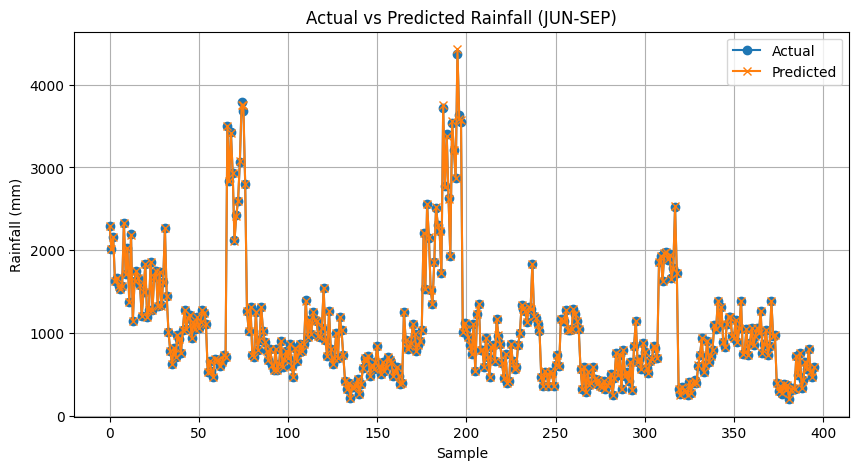

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred_best, label='Predicted', marker='x')
plt.title('Actual vs Predicted Rainfall (JUN-SEP)')
plt.xlabel('Sample')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True)
plt.show()


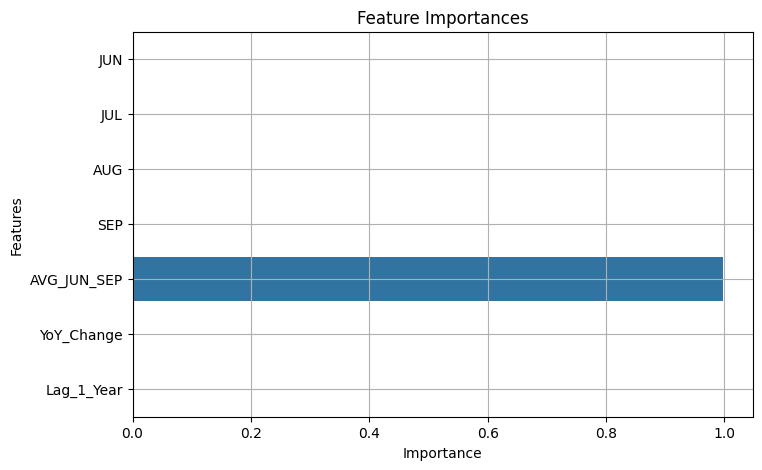

In [18]:
import seaborn as sns

importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


In [19]:
# arima

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Assuming df is your DataFrame
subdivision_name = "ANDAMAN & NICOBAR ISLAND"
df_sub = df[df['subdivision'] == subdivision_name].sort_values('YEAR')

# Set year as index and use JUN-SEP rainfall
rainfall_ts = df_sub.set_index('YEAR')['TOTAL']


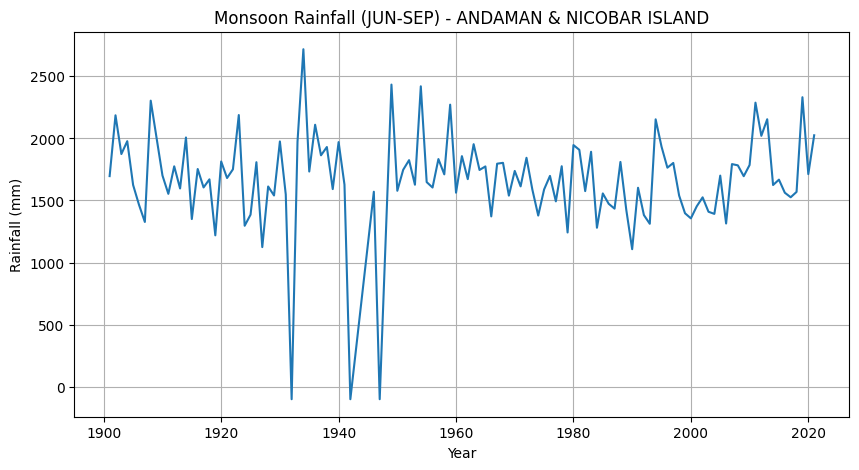

In [21]:
plt.figure(figsize=(10,5))
plt.plot(rainfall_ts)
plt.title(f'Monsoon Rainfall (JUN-SEP) - {subdivision_name}')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()


In [22]:
model = ARIMA(rainfall_ts, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  TOTAL   No. Observations:                  116
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -856.179
Date:                Tue, 01 Jul 2025   AIC                           1718.358
Time:                        13:26:38   BIC                           1726.593
Sample:                             0   HQIC                          1721.701
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0213      0.104     -0.204      0.838      -0.226       0.183
ma.L1         -0.9999      7.406     -0.135      0.893     -15.515      13.515
sigma2      1.642e+05   1.21e+06      0.136      0.8

116    1653.384000
117    1661.296325
118    1661.127904
119    1661.131489
120    1661.131413
Name: predicted_mean, dtype: float64


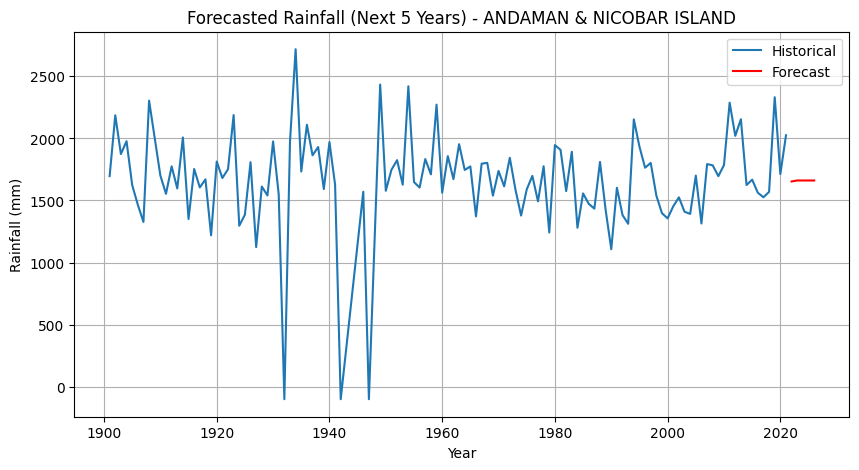

In [23]:
forecast = model_fit.forecast(steps=5)
print(forecast)

# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(rainfall_ts, label='Historical')
plt.plot(range(rainfall_ts.index[-1]+1, rainfall_ts.index[-1]+6), forecast, label='Forecast', color='red')
plt.legend()
plt.title(f'Forecasted Rainfall (Next 5 Years) - {subdivision_name}')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()


In [24]:
# clustering subdivisions based on rainfall patterns

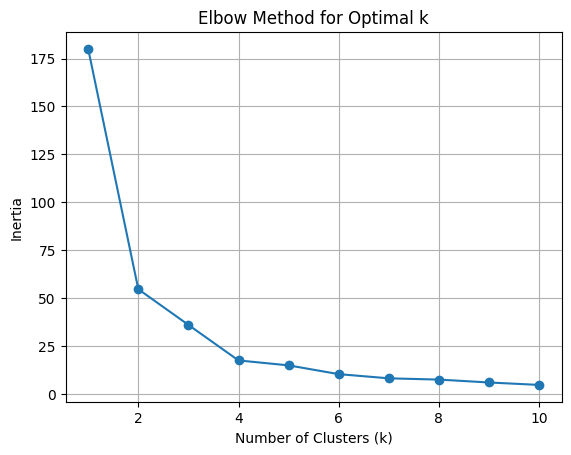

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate average JUN-SEP rainfall per subdivision
rainfall_avg = df.groupby('subdivision')[['JUN', 'JUL', 'AUG', 'SEP', 'TOTAL']].mean()

# Step 2: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rainfall_avg)

# Step 3: Find optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_data)
    inertia.append(model.inertia_)

# Plot the Elbow Curve
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


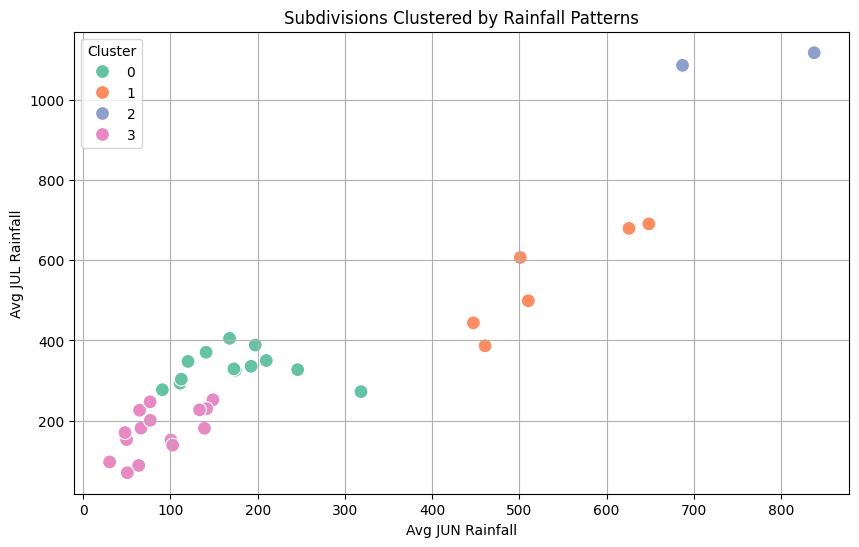

,subdivision,Cluster
0,ANDAMAN & NICOBAR ISLAND,1
1,ARUNACHAL PRADESH,1
2,ASSAM & MEGHALAYA,1
3,BIHAR,0
4,CHATHISGARH,0
5,COASTAL ANDHRA PRADESH & YANAM,3
6,COASTAL KARNATAKA,2
7,EAST MADHYA PRADESH,0
8,EAST RAJASTHAN,3
9,EAST UTTAR PRADESH,0


In [26]:
# Apply KMeans with optimal k (say 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Assign cluster labels to subdivisions
rainfall_avg['Cluster'] = clusters

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rainfall_avg, x='JUN', y='JUL', hue='Cluster', palette='Set2', s=100)
plt.title('Subdivisions Clustered by Rainfall Patterns')
plt.xlabel('Avg JUN Rainfall')
plt.ylabel('Avg JUL Rainfall')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# Optional: Check which subdivisions are in which cluster
rainfall_avg.reset_index()[['subdivision', 'Cluster']]


In [27]:
# trend shifts and climate change indicators

In [28]:
# Create a 'decade' column
df['decade'] = (df['YEAR'] // 10) * 10

# Calculate average JUN-SEP rainfall per decade for each subdivision
decade_trend = df.groupby(['subdivision', 'decade'])['TOTAL'].mean().reset_index()


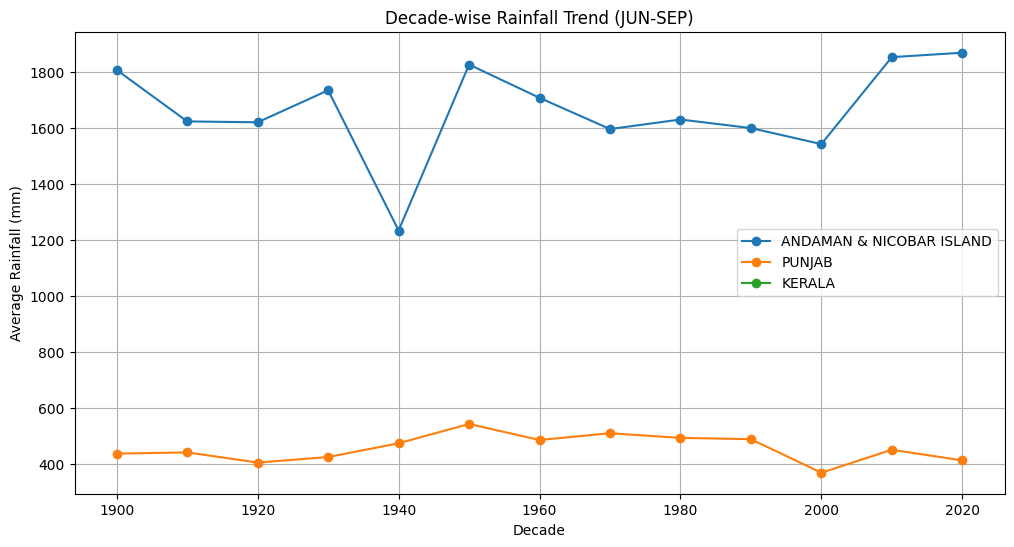

In [29]:
# Choose a few subdivisions to visualize
sample_subdivisions = ['ANDAMAN & NICOBAR ISLAND', 'PUNJAB', 'KERALA']

plt.figure(figsize=(12, 6))

for sub in sample_subdivisions:
    sub_data = decade_trend[decade_trend['subdivision'] == sub]
    plt.plot(sub_data['decade'], sub_data['TOTAL'], marker='o', label=sub)

plt.title('Decade-wise Rainfall Trend (JUN-SEP)')
plt.xlabel('Decade')
plt.ylabel('Average Rainfall (mm)')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from scipy.stats import linregress

# Calculate slope for each subdivision
trend_slopes = []

for sub in df['subdivision'].unique():
    sub_data = decade_trend[decade_trend['subdivision'] == sub]
    if len(sub_data) > 1:
        slope, _, _, _, _ = linregress(sub_data['decade'], sub_data['TOTAL'])
        trend_slopes.append({'subdivision': sub, 'slope': slope})

trend_df = pd.DataFrame(trend_slopes)

# Top increasing and decreasing rainfall regions
trend_df.sort_values(by='slope', ascending=False).head(5)  # Increasing
trend_df.sort_values(by='slope', ascending=True).head(5)   # Decreasing


,subdivision,slope
1,ARUNACHAL PRADESH,-13.998424
21,"NAGALAND, MANIPUR, MIZORAM, TRIPURA",-4.828903
13,HIMACHAL PRADESH,-1.876467
16,KERALA & MAHE,-1.804879
31,UTTARANCHAL,-1.674663


In [31]:
df.to_csv('rainfall_full_data.csv', index=False)

In [32]:
df.head()

,subdivision,YEAR,JUN,JUL,AUG,SEP,TOTAL,AVG_RAINFALL,AVG_JUN_SEP,YoY_Change,Lag_1_Year,decade
0,ANDAMAN & NICOBAR ISLAND,1901,517.5,365.1,481.1,332.6,1696.3,424.075,424.075,NaN,NaN,1900
1,ANDAMAN & NICOBAR ISLAND,1902,537.1,228.9,753.7,666.2,2185.9,546.475,546.475,489.6,1696.3,1900
2,ANDAMAN & NICOBAR ISLAND,1903,479.9,728.4,326.7,339.0,1874.0,468.500,468.500,-311.9,2185.9,1900
3,ANDAMAN & NICOBAR ISLAND,1904,495.1,502.0,160.1,820.4,1977.6,494.400,494.400,103.6,1874.0,1900
4,ANDAMAN & NICOBAR ISLAND,1905,628.7,368.7,330.5,297.0,1624.9,406.225,406.225,-352.7,1977.6,1900
